In [28]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import functools
import math


def mean(x):
    x = list(x)
    return sum(x) / len(x)


def median(x):
    x = sorted(list(x))
    return x[len(x) // 2]


@functools.lru_cache(None)
def load_runs(log_dir):
    runs = []
    for f in sorted(glob.glob("{}/*.pkl".format(log_dir))):
        print(f)
        with open(f, 'rb') as f:
            torch.load(f)
            try:
                runs.append(torch.load(f, map_location='cpu'))
            except EOFError:
                pass

    return runs


def triangle(a, b, c, d=None, slope=None, other=False, color=None, fmt="{:.2f}", textpos=None):
    import math
    
    if slope is not None and d is None:
        d = math.exp(math.log(c) + slope * (math.log(b) - math.log(a)))
    if slope is not None and c is None:
        c = math.exp(math.log(d) - slope * (math.log(b) - math.log(a)))
    if color is None:
        color = 'k'

    plt.plot([a, b], [c, d], color=color)
    if other:
        plt.plot([a, b], [c, c], color=color)
        plt.plot([b, b], [c, d], color=color)
    else:
        plt.plot([a, b], [d, d], color=color)
        plt.plot([a, a], [c, d], color=color)

    s = (math.log(d) - math.log(c)) / (math.log(b) - math.log(a))
    if other:
        x = math.exp(0.7 * math.log(b) + 0.3 * math.log(a))
        y = math.exp(0.7 * math.log(c) + 0.3 * math.log(d))
    else:
        x = math.exp(0.7 * math.log(a) + 0.3 * math.log(b))
        y = math.exp(0.7 * math.log(d) + 0.3 * math.log(c))
    if textpos:
        x = textpos[0]
        y = textpos[1]
    plt.annotate(fmt.format(s), (x, y), horizontalalignment='center', verticalalignment='center')
    return s

In [29]:
def nd(x, a):
    assert not torch.isnan(x['outputs']).any()
    return (a * x['outputs'] * x['labels'] < 1).nonzero().numel()

def err(x):
    assert not torch.isnan(x['outputs']).any()
    return (x['outputs'] * x['labels'] <= 0).double().mean().item()

def enserr(xs):
    f = mean(x['outputs'] for x in xs)
    y = xs[0]['labels']
    assert all((x['labels'] == y).all() for x in xs)
    return (f * y <= 0).double().mean().item()

def texnum(x, mfmt='{}'):
    m, e = "{:e}".format(x).split('e')
    m, e = float(m), int(e)
    mx = mfmt.format(m)
    if e == 0:
        return mx
    ex = "10^{{{}}}".format(e)
    if m == 1:
        return ex
    return "{}\;{}".format(mx, ex)

def logfilter(x, y, num):
    import numpy as np
    import scipy.ndimage
    x = np.array(x)
    y = np.array(y)
    x = np.log(x)
    xi = np.linspace(min(x), max(x), num)
    yi = np.interp(xi, x, y)
    yf = scipy.ndimage.filters.gaussian_filter1d(yi, 2)
    return np.exp(xi), yf

def yavg(xi, x, y):
    import numpy as np
    y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]
    return xi, y

# Disentangling the mean-field regime from lazy training from performance

`python -m grid nd_M10d5L5kP_h_alpha "python main.py --arch fc_relu --data_seed 0 --batch_seed 0 --d 10 --L 5 --dataset mnist --ptr 5000 --max_bs 5000 --pte 50000 --train_time 36000 --temp 0 --tau -1000 --final_kernel 0" --alpha:float 0.001 0.01 0.1 1 10 100 1000 --init_seed:int 0 --h:int 4 5 7 8 9 10 11 12 13 14 15 17 18 20 21 23 25 28 30 33 36 39 43 46 51 55 60 66 71 77 83 90 98 106 115 125 135 159 188 221 261 307 362 426 502 591 696 820 965 1137 1339 1577 --init_kernel:int 0`

`python -m grid nd_MCV5kP_alpha_2 "python main.py --dtype float64 --arch cv_relu --data_seed 0 --batch_seed 0 --dataset mnist --ptr 5000 --max_bs 64 --pte 50000 --train_time 18000 --temp 3e-4 --tau 10 --init_kernel 0 --final_kernel 0" --h:int 10 12 14 17 20 23 28 33 39 46 55 66 77 90 106 125 159 --init_seed:int 0 1 --alpha:float 0.01 0.1 1 10 100`

`python -m grid nd_M10d5L5kP_alpha_sp_1 "python main.py --arch fc_softplus --data_seed 0 --batch_seed 0 --d 10 --L 5 --dataset mnist --ptr 5000 --max_bs 5000 --pte 50000 --train_time 36000 --temp 0 --tau -1000 --init_kernel 1 --final_kernel 1 --delta_kernel 1 --spbeta 5 --spsig 1.40438" --init_seed:int 0 1 2 3 4 5 6 7 8 9 --alpha:float 1e-3 2.2e-3 4.6e-3 1e-2 2.2e-2 4.6e-2 1e-1 2.2e-1 4.6e-1 1 2.2 4.6 1e1 2.2e1 4.6e1 1e2 2.2e2 4.6e2 1e3 2.2e3 4.6e3 1e4 2.2e4 4.6e4 1e5 --h:int 100 200 400 800`

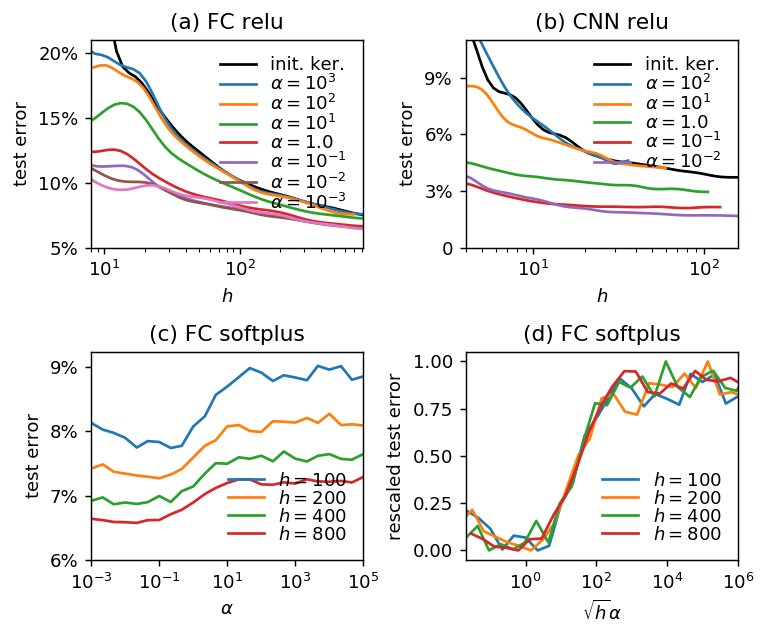

In [31]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6, 5), dpi=130)

plt.sca(ax1)
runs = load_runs("nd_M10d5L5kP_h_alpha")
runs = [r for r in runs if 'init_kernel' in r]
runs = [r for r in runs if not torch.isnan(r['init_kernel']['test']['outputs']).any()]
runs = [r for r in runs if nd(r['init_kernel']['train'], r['args'].alpha) == 0 or r['args'].h < 100]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(*logfilter(hs, vs, 50), label=r'init. ker.', color='k')

runs = load_runs("nd_M10d5L5kP_h_alpha")
runs = [r for r in runs if 'regular' in r]
runs = [r for r in runs if not torch.isnan(r['regular']['test']['outputs']).any()]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0 or r['args'].h < 100]

for a in sorted({r['args'].alpha for r in runs}, reverse=True):
    rs = [r for r in runs if r['args'].alpha == a]

    hs = sorted({r['args'].h for r in rs})
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].h == h) for h in hs]
    plt.plot(*logfilter(hs, vs, 50), label=r'$\alpha = {}$'.format(texnum(a)))


plt.yticks([0, 0.05, 0.10, 0.15, 0.20], ['0', '5%', '10%', '15%', '20%'])
plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
plt.ylabel('test error')
plt.ylim(0.05, 0.21)
plt.xlim(8, 820)
plt.title('(a) FC relu')



plt.sca(ax2)
runs = load_runs("nd_MCV5kP_alpha_2")
runs = [r for r in runs if 'init_kernel' in r]
runs = [r for r in runs if nd(r['init_kernel']['train'], r['args'].alpha) == 0 or r['args'].h < 30]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(*logfilter(hs, vs, 50), label=r'init. ker.', color='k')

runs = load_runs("nd_MCV5kP_alpha_2")
runs = [r for r in runs if 'regular' in r]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0 or r['args'].h < 30]

for a in sorted({r['args'].alpha for r in runs}, reverse=True):
    rs = [r for r in runs if r['args'].alpha == a]

    hs = sorted({r['args'].h for r in rs})
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].h == h) for h in hs]
    plt.plot(*logfilter(hs, vs, 50), label=r'$\alpha = {}$'.format(texnum(a)))

plt.yticks([0, 0.03, 0.06, 0.09], ['0', '3%', '6%', '9%'])
plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
plt.ylabel('test error')
plt.ylim(0, 0.11)
plt.xlim(4, 159)
plt.title('(b) CNN relu')



plt.sca(ax3)
runs = load_runs("nd_M10d5L5kP_alpha_sp_1")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, '-', label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel(r'$\alpha$')
plt.ylabel('test error')
plt.yticks([0.06, 0.07, 0.08, 0.09], ['6%', '7%', '8%', '9%'])
plt.xlim(1e-3, 1e5)
plt.title('(c) FC softplus')



plt.sca(ax4)
runs = load_runs("nd_M10d5L5kP_alpha_sp_1")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a * h ** 0.5 for a in als]
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    vs = [(x - min(vs)) / (max(vs) - min(vs)) for x in vs]
    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('rescaled test error')
plt.xlim(2e-2, 1e6)
plt.title('(d) FC softplus')


plt.tight_layout()
plt.savefig('vary_alpha.pgf')

# Fluctuations of output function and effect of ensemble averaging

`python -m grid nd_M10d5L5kP_h_sp_1 "python main.py --arch fc_softplus --data_seed 0 --batch_seed 0 --d 10 --L 5 --dataset mnist --ptr 5000 --max_bs 5000 --pte 50000 --train_time 36000 --temp 0 --tau -1000 --init_kernel 0 --final_kernel 0 --delta_kernel 0 --spbeta 5 --spsig 1.40438" --init_seed:int 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 50 51 52 53 54 55 56 57 58 59 --sqhalpha:float 1e-2 1e6 --h:int 50 71 100 141 200 283 400 566 800`

data `M5kP_cv_sgd` are older and generated from another script with momentum dynamics defined in pytorch i.e. not a continuous dynamics. We are confident that we would get the same results with the current script.

`python -m grid nd_MCV5kP_alpha_3 "python main.py --dtype float64 --arch cv_relu --data_seed 0 --batch_seed 0 --dataset mnist --ptr 5000 --max_bs 64 --pte 50000 --train_time 18000 --temp 3e-4 --tau 10 --init_kernel 0 --final_kernel 0" --init_seed:int 0 1 2 3 4 5 6 7 8 9 --h:int 10 12 14 17 20 23 28 33 39 46 55 66 77 90 106 125 159 --alpha:float 1e-4`

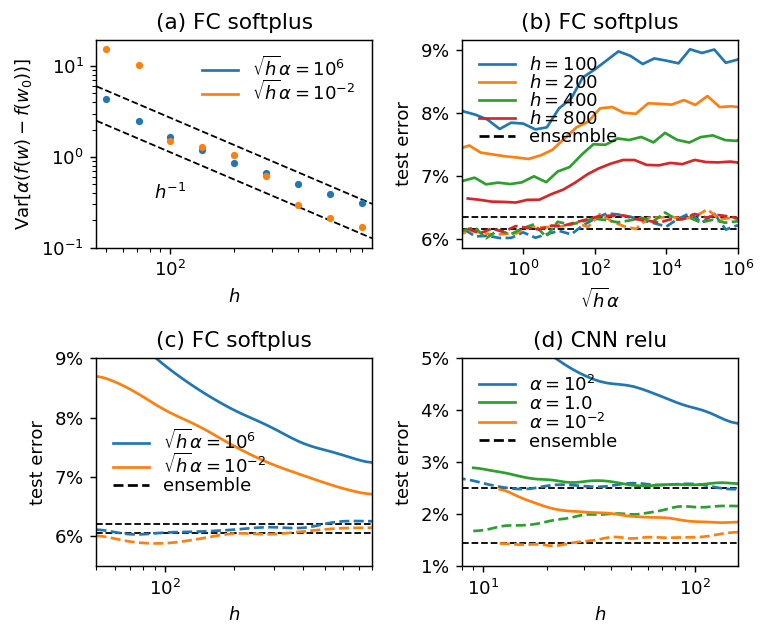

In [33]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6, 5), dpi=130)


plt.sca(ax1)
runs = load_runs("nd_M10d5L5kP_h_sp_1")
runs = [r for r in runs if not torch.isnan(r['regular']['test']['outputs']).any()]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0 or r['args'].h < 100]

hals = sorted({r['args'].sqhalpha for r in runs})

def var(xs):
    n = len(xs)
    m = mean(xs)
    return sum((x - m).pow(2).mean().item() for x in xs) / (n - 1)

for ha in reversed(hals):
    rs = [r for r in runs if r['args'].sqhalpha == ha]
    hs = sorted({r['args'].h for r in rs})
#     print([len([1 for r in rs if r['args'].h == h]) for h in hs])
    n = 26
#     print(n)
    rs = [r for rs in [[r for r in rs if r['args'].h == h] for h in hs] if len(rs) >= n for r in rs[:n]]
    hs = sorted({r['args'].h for r in rs})
    vs = [var([r['args'].alpha * r['regular']['test']['outputs'] for r in rs if r['args'].h == h]) for h in hs]
    [line, _, _] = plt.errorbar(hs, vs, fmt='.')
    plt.plot([], [], label=r'$\sqrt{{h}}\alpha = {}$'.format(texnum(ha)), color=line.get_color())

plt.xlim(hs[0] * 0.9, hs[-1] / 0.9)
plt.yscale('log')
plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.ylabel(r'$\mathrm{Var}[ \alpha(f(w) - f(w_0)) ]$')
a, b = plt.xlim()
for c in [2.5, 6]:
    plt.plot([a, b], [c, c * (b / a) ** -1], 'k--', linewidth=1, zorder=-10)
plt.annotate(r"$h^{-1}$", (1e2, 4e-1), horizontalalignment='center', verticalalignment='center')
plt.xlabel(r'$h$')
plt.title('(a) FC softplus')





plt.sca(ax2)
runs = load_runs("nd_M10d5L5kP_alpha_sp_1")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
#     print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
#     print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a * h ** 0.5 for a in als]
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(*(ws, vs), '-', label=r'$h = {}$'.format(h))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(*(ws, vs), '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(2e-2, 1e6)
y = [6, 7, 8, 9]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
plt.plot(plt.xlim(), [0.0615] * 2, 'k--', linewidth=1, zorder=-10)
plt.plot(plt.xlim(), [0.0635] * 2, 'k--', linewidth=1, zorder=-10)
plt.title('(b) FC softplus')





plt.sca(ax3)
runs = load_runs("nd_M10d5L5kP_h_sp_1")
runs = [r for r in runs if not torch.isnan(r['regular']['test']['outputs']).any()]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0 or r['args'].h < 100]

hals = sorted({r['args'].sqhalpha for r in runs})

for ha in reversed(hals):
    rs = [r for r in runs if r['args'].sqhalpha == ha]
    hs = sorted({r['args'].h for r in rs})
#     print([len([1 for r in rs if r['args'].h == h]) for h in hs])
    n = 26
#     print(n)
    rs = [r for rs in [[r for r in rs if r['args'].h == h] for h in hs] if len(rs) >= n for r in rs[:n]]
    hs = sorted({r['args'].h for r in rs})
    
    vs = [mean([err(r['regular']['test']) for r in rs if r['args'].h == h]) for h in hs]
    [line] = plt.plot(*logfilter(hs, vs, 50), label=r'$\sqrt{{h}} \alpha = {}$'.format(texnum(ha)))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].h == h]) for h in hs]
    plt.plot(*logfilter(hs, vs, 50), '--', color=line.get_color())

plt.xlim(50, 800)
plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
y = [6, 7, 8, 9]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
plt.ylim(0.055, 0.09)
plt.ylabel(r'test error')
plt.xlabel(r'$h$')
for e in [0.0605, 0.0620]:
    plt.plot(plt.xlim(), [e] * 2, 'k--', linewidth=1, zorder=-10)
plt.title('(c) FC softplus')





plt.sca(ax4)
runs = load_runs('M5kP_cv_sgd') + load_runs('M5kP_sgd')
runs = [r for r in runs if nd(r['regular']['train'], 1) == 0]
# runs += [r for r in load_runs('nd_MCV5kP_alpha_3') if nd(r['regular']['train'], r['args'].alpha) == 0]

for r in runs:
    if not hasattr(r['args'], 'alpha'):
        r['args'].alpha = 1

als = sorted({r['args'].alpha for r in runs})

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

for alpha, color in zip(reversed(als), [c[0], c[2], c[1]]):
    rs = [r for r in runs if r['args'].alpha == alpha]
    hs = sorted({r['args'].h for r in rs})
#     print([len([1 for r in rs if r['args'].h == h]) for h in hs])
    
    n = 20 if alpha != 1e-4 else 10
#     print(n)
    
    rs = [r for rs in [[r for r in rs if r['args'].h == h] for h in hs] if len(rs) >= n for r in rs[:n]]
    hs = sorted({r['args'].h for r in rs})
    
    vs = [mean([err(r['regular']['test']) for r in rs if r['args'].h == h]) for h in hs]
    [line] = plt.plot(*logfilter(hs, vs, 50), color=color, label=r'$\alpha = {}$'.format(texnum(alpha)))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].h == h]) for h in hs]
    plt.plot(*logfilter(hs, vs, 50), '--', color=line.get_color())
    
#     print(min(vs))

from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xscale('log')
plt.xlim(8, hs[-1])
y = [1, 2, 3, 4, 5]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
plt.ylim(0.01, 0.05)
plt.xlabel(r'$h$')
plt.ylabel('test error')
plt.title('(d) CNN relu')
for e in [0.0145, 0.025]:
    plt.plot(plt.xlim(), [e] * 2, 'k--', linewidth=1, zorder=-10)






plt.tight_layout()
plt.savefig('var_ens.pgf')

# Training dynamics differs in the two regimes

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
10


-1.7

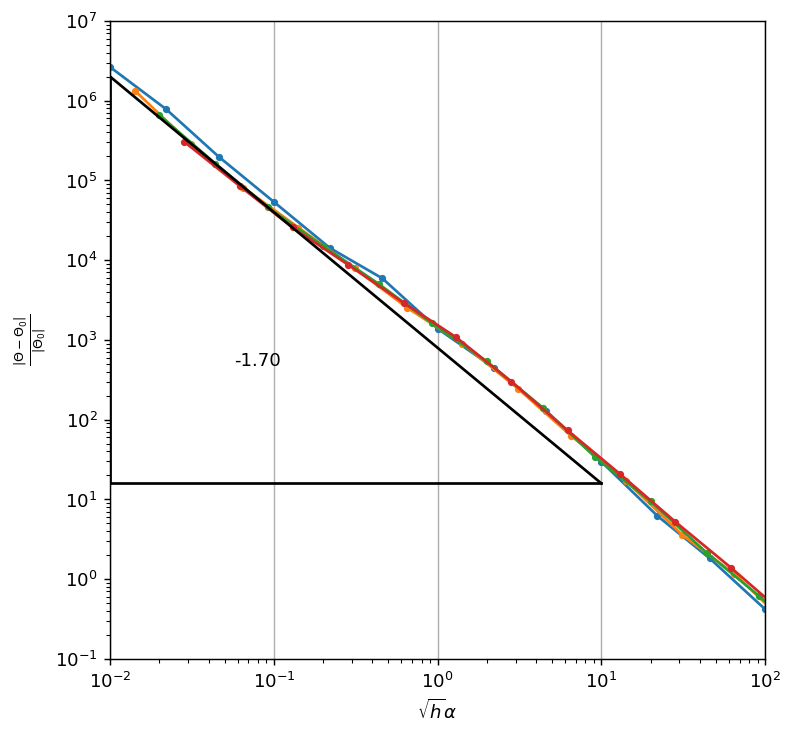

In [34]:
runs = load_runs("nd_M10d5L5kP_alpha_sp_1")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

fig, ax2 = plt.subplots(1, 1, figsize=(6.5, 6.5), dpi=130)

##
def thth0(r):
    x = r['init_kernel']['kernel']['test']
    th0 = x['diag'].numel() * (x['mean'] ** 2 + x['std'] ** 2) ** 0.5
    dth = r['delta_kernel']['test']
    return dth / th0

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})
    
    ws = [a * h ** 0.5 for a in als]

    plt.sca(ax2)
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(ws, vs, '.-', label=r'$h = {}$'.format(h))
        



# y-axis
plt.sca(ax2)
plt.yscale('log')
plt.ylim(1e-1, 1e7)
plt.sca(ax2)
plt.ylabel(r'$\frac{\|\Theta - \Theta_0\|}{\|\Theta_0\|}$')

# x-axis
plt.sca(ax2)
plt.grid(axis='x')
plt.xlim(1e-2, 1e2)
plt.xscale('log')

plt.sca(ax2)
plt.xlabel(r'$\sqrt{h} \alpha$')

triangle(1e-2, 1e1, 2e6, slope=-1.7)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]


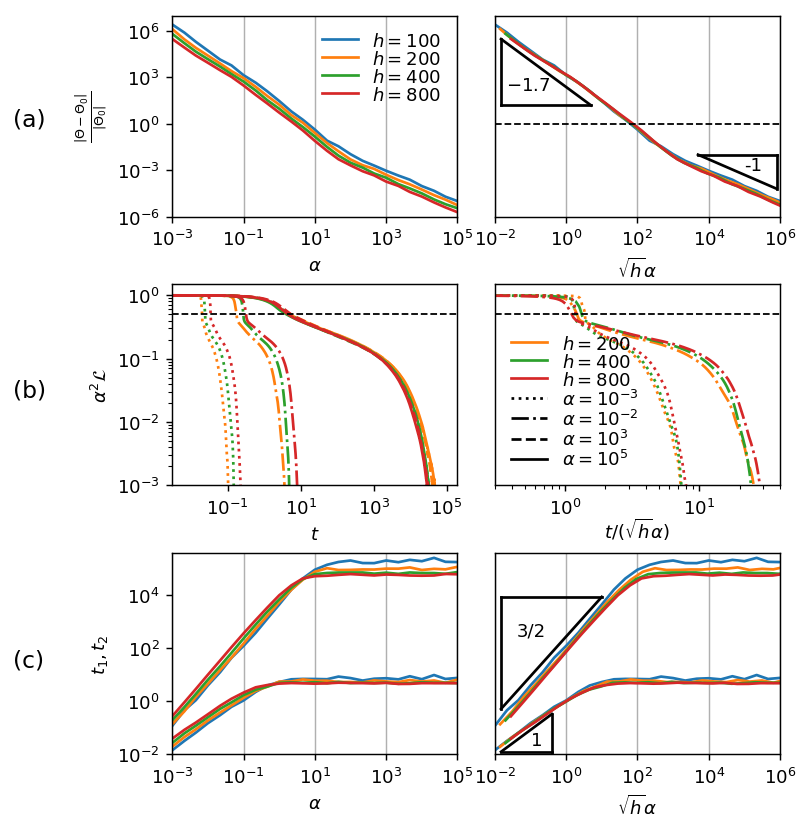

In [35]:
runs = load_runs("nd_M10d5L5kP_alpha_sp_1")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2, figsize=(6.5, 6.5), dpi=130)

##
def thth0(r):
    x = r['init_kernel']['kernel']['test']
    th0 = x['diag'].numel() * (x['mean'] ** 2 + x['std'] ** 2) ** 0.5
    dth = r['delta_kernel']['test']
    return dth / th0

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})
    
    ws = [a * h ** 0.5 for a in als]

    plt.sca(ax2)
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))
    
    plt.sca(ax1)
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, '-', label=r'$h = {}$'.format(h))
        

# y-axis
for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.yscale('log')
    plt.ylim(1e-6, 1e7)
plt.sca(ax1)
plt.ylabel(r'$\frac{\|\Theta - \Theta_0\|}{\|\Theta_0\|}$')

plt.sca(ax2)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off
    labelleft=False)   # labels along the bottom edge are off


# x-axis
plt.sca(ax1)
plt.grid(axis='x')
plt.xlim(1e-3, 1e5)
plt.xscale('log')
plt.xlabel(r'$\alpha$')

plt.sca(ax2)
plt.grid(axis='x')
plt.xlim(1e-2, 1e6)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.sca(ax1)
plt.legend(labelspacing=0, frameon=False)

plt.sca(ax2)
triangle(1.5e-2, 5e0, 3e5, slope=-1.7, fmt=r"${:.1f}$")
triangle(5e3, 8e5, 1e-2, slope=-1, other=True, fmt="-1")
plt.plot(plt.xlim(), [1, 1], '--k', linewidth=1)




##
hs = list(zip([200, 400, 800], plt.rcParams['axes.prop_cycle'].by_key()['color'][1:4]))
als = list(zip([0.001, 0.01, 1e3, 1e5], [':', '-.', '--', '-']))

for h, color in hs:
    for a, linestyle in als:
        key = lambda r: r['regular']['dynamics'][-1]['t']
        r = sorted([r for r in runs if r['args'].h == h and r['args'].alpha == a], key=key)[0]
    
        d = r['regular']['dynamics']
        c = a * h ** 0.5
        
        plt.sca(ax3)
        plt.plot([x['t'] for x in d], [x['train']['loss'] * a**2 for x in d], color=color, linestyle=linestyle)

        if a < 1:
            plt.sca(ax4)
            plt.plot([x['t'] / c for x in d], [x['train']['loss'] * a**2 for x in d], color=color, linestyle=linestyle)

for ax in [ax3, ax4]:
    plt.sca(ax)
    plt.yscale('log')
    plt.ylim(1e-3, 1.5)
    
plt.sca(ax3)
plt.ylabel(r'$\alpha^2 \mathcal{L}$')

plt.sca(ax3)
plt.xlabel(r'$t$')
plt.xscale('log')
plt.xlim(3e-3, 2e5)

plt.sca(ax4)
plt.xlabel(r'$t/(\sqrt{h} \alpha)$', labelpad=-1)
plt.xscale('log')
plt.xlim(3e-1, 4e1)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color) for h, color in hs] + [Line2D([0], [0], color='k', linestyle=linestyle) for a, linestyle in als]
texts = [r'$h={}$'.format(h) for h, color in hs] + [r'$\alpha={}$'.format(texnum(a)) for a, linestyle in als]
ax4.legend(custom_lines, texts, frameon=False, labelspacing=0)

for ax in [ax3, ax4]:
    plt.sca(ax)
    plt.plot(plt.xlim(), [0.5] * 2, 'k--', linewidth=1)

    

    
##
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})
    
    ws = [a * h ** 0.5 for a in als]


    plt.sca(ax6)
    vs = [mean(r['regular']['dynamics'][-1]['t'] for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))

    vs = [mean(
        next(x['t'] for x in r['regular']['dynamics'] if x['train']['loss'] * r['args'].alpha ** 2 < 0.5)
        for r in rs if r['args'].alpha == a)
    for a in als]
    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h), color=line.get_color())

    plt.sca(ax5)
    vs = [mean(r['regular']['dynamics'][-1]['t'] for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(als, vs, '-', label=r'$h = {}$'.format(h))

    vs = [mean(
        next(x['t'] for x in r['regular']['dynamics'] if x['train']['loss'] * r['args'].alpha ** 2 < 0.5)
        for r in rs if r['args'].alpha == a)
    for a in als]
    plt.plot(als, vs, '-', label=r'$h = {}$'.format(h), color=line.get_color())


# y-axis
for ax in [ax5, ax6]:
    plt.sca(ax)
    plt.ylim(1e-2, 4e5)
    plt.yscale('log')
plt.sca(ax5)
plt.ylabel(r'$t_1, t_2$')

for ax in [ax4, ax6]:
    plt.sca(ax)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the bottom edge are off
        right=False,       # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

plt.sca(ax5)
plt.grid(axis='x')
plt.xlim(1e-3, 1e5)
plt.xscale('log')
plt.xlabel(r'$\alpha$')

plt.sca(ax6)
plt.grid(axis='x')
plt.xlim(1e-2, 1e6)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.sca(ax6)
triangle(1.5e-2, 1e1, 5e-1, slope=3/2, fmt="3/2")
triangle(1.5e-2, 4e-1, 1.2e-2, slope=1, other=True, fmt="1")

fig.text(0, 0.85, r"(a)", verticalalignment='center', horizontalalignment='left', fontsize=13)
fig.text(0, 0.53, r"(b)", verticalalignment='center', horizontalalignment='left', fontsize=13)
fig.text(0, 0.21, r"(c)", verticalalignment='center', horizontalalignment='left', fontsize=13)

plt.tight_layout(h_pad=0, w_pad=0, rect=[0.05, 0, 0.95, 1])
plt.savefig('time_dynamics.pgf')

# Frozen NTK dynamics

`python -m grid nd_M10d5L5kP "python main.py --arch fc_relu --data_seed 0 --batch_seed 0 --d 10 --L 5 --dataset mnist --ptr 5000 --max_bs 5000 --pte 50000 --train_time 18000 --temp 0 --init_kernel 1 --final_kernel 1" --h:int 1419 1262 1124 1000 890 791 704 626 557 495 441 392 349 310 276 245 218 194 173 154 137 122 108 96 86 76 68 60 54 48 42 38 34 30 27 24 21 19 17 15 13 --init_seed:int 0 1 2`

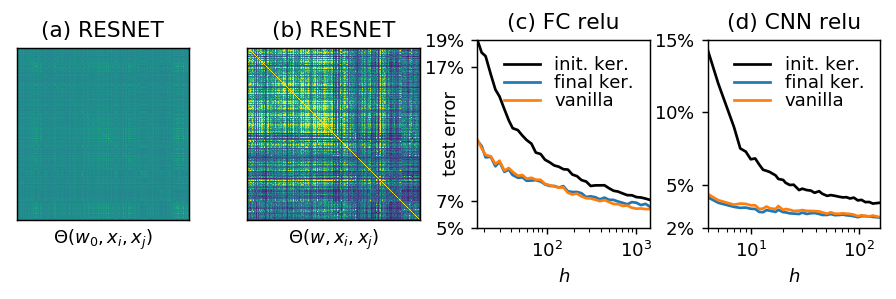

In [38]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(7, 2.4), dpi=130)


runs = load_runs("wide_resnet_6k")
r = runs[0]

import dataset
x, y = dataset.get_normalized_dataset(r['args'].dataset, r['args'].data_seed)

y = y[r['args'].ptr: r['args'].ptr + r['args'].pte].clone()
y[y % 2 == 0] += 100
y, i = y.sort()
y[y % 2 == 0] -= 100

for ax, name in [(ax1, 'init_kernel'), (ax2, 'final_kernel')]:
    plt.sca(ax)
    k = r[name]['kernel']['test']['value']
    k = k[i][:, i] / k.norm() * k.numel() ** 0.5
    plt.imshow(k, vmin=0.1, vmax=1.9)

if r['args'].dataset == 'cifar10':
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
else:
    classes = [str(i) for i in range(10)]
    
for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the bottom edge are off
        right=False,       # ticks along the top edge are off
        bottom=False,
        top=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off


#     for i in range(9):
#         i = (2 * i + 1) % 11
#         plt.plot([-0.5, len(y) - 0.5], [(y == i).nonzero()[-1][0].item() + 0.5] * 2, 'k:')

#     for i in range(9):
#         i = (2 * i + 1) % 11
#         plt.plot([(y == i).nonzero()[-1][0].item() + 0.5] * 2, [-0.5, len(y) - 0.5], 'k:')
    
    a = 0
    plt.xlim(-1 - a, len(y) + a)
    plt.ylim(len(y) + a, -1 - a)

#     plt.plot([-0.5, len(y) - 0.5], [(y % 2 == 1).nonzero()[-1][0].item() + 0.5] * 2, 'r')
#     plt.plot([(y % 2 == 1).nonzero()[-1][0].item() + 0.5] * 2, [-0.5, len(y) - 0.5], 'r')

plt.sca(ax1)
# plt.yticks([(y == i).nonzero().median().item() for i in range(10)], classes);


plt.sca(ax1)
plt.title(r'(a) RESNET')
plt.xlabel(r'$\Theta(w_0, x_i, x_j)$')

plt.sca(ax2)
plt.title(r'(b) RESNET')
plt.xlabel(r'$\Theta(w, x_i, x_j)$')




plt.sca(ax3)
runs = load_runs("nd_M10d5L5kP")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'init. ker.', color='k')

vs = [mean(err(r['final_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'final ker.')

vs = [mean(err(r['regular']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'vanilla')

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
plt.ylabel('test error', labelpad=-20)
plt.ylim(0.05, 0.19)
plt.xlim(hs[0], hs[-1])
y = [5, 7, 17, 19]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
plt.title('(c) FC relu')



plt.sca(ax4)
runs = load_runs("nd_MCV5kP_3")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) < 0.01 * r['args'].ptr]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'init. ker.', color='k')

vs = [mean(err(r['final_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'final ker.')

vs = [mean(err(r['regular']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'vanilla')

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
# plt.ylabel('test error')
plt.ylim(0.02, 0.15)
plt.xlim(hs[0], hs[-1])
y = [2, 5, 10, 15]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
plt.title('(d) CNN relu')


plt.tight_layout(w_pad=0)
plt.savefig('kernel_dyn.pgf')

# Dynamics of the Weights

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]


-0.23000000000000004

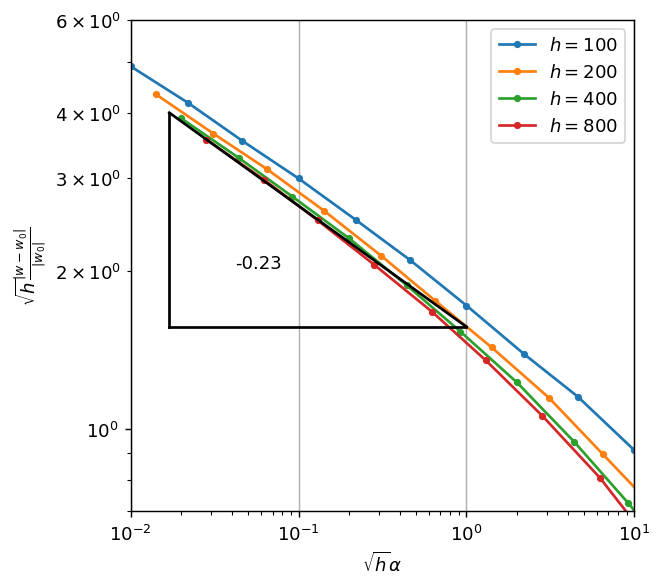

In [39]:
fig, ax2 = plt.subplots(1, 1, figsize=(5, 5), dpi=130)

runs = load_runs("nd_M10d5L5kP_alpha_sp_1")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})
    
    ws = [a * h ** 0.5 for a in als]

    plt.sca(ax2)
    vs = [h ** 0.5 * 
          mean(r['regular']['dynamics'][-1]['dnorm'] / r['regular']['dynamics'][0]['norm'] 
               for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(ws, vs, '.-', label=r'$h = {}$'.format(h))


# y-axis
plt.sca(ax2)
plt.ylim(7e-1, 6e0)
plt.yscale('log')
plt.ylabel(r'$\sqrt{h} \frac{\| w - w_0 \|}{\|w_0\|}$')

# x-axis
plt.sca(ax2)
plt.grid(axis='x')
plt.xlim(1e-2, 1e1)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')
plt.legend()

L = 5
plt.sca(ax2)
triangle(1.7e-2, 1e0, 4, slope=-0.23)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8]


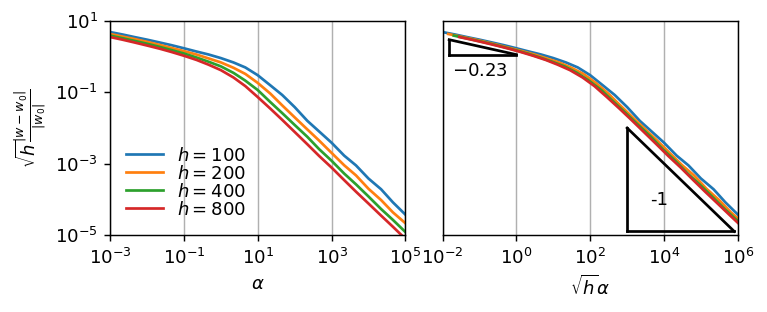

In [40]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6, 2.5), dpi=130)

runs = load_runs("nd_M10d5L5kP_alpha_sp_1")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})
    
    ws = [a * h ** 0.5 for a in als]

    plt.sca(ax2)
    vs = [h ** 0.5 * 
          mean(r['regular']['dynamics'][-1]['dnorm'] / r['regular']['dynamics'][0]['norm'] 
               for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))

    
    plt.sca(ax1)
    vs = [h ** 0.5 * 
          mean(r['regular']['dynamics'][-1]['dnorm'] / r['regular']['dynamics'][0]['norm'] 
               for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, '-', label=r'$h = {}$'.format(h))
        



# y-axis
for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.ylim(1e-5, 1e1)
    plt.yscale('log')

plt.sca(ax1)
plt.ylabel(r'$\sqrt{h} \frac{\| w - w_0 \|}{\|w_0\|}$')

plt.sca(ax2)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


# x-axis
plt.sca(ax1)
plt.grid(axis='x')
plt.xlim(1e-3, 1e5)
plt.xscale('log')
plt.xlabel(r'$\alpha$')

plt.sca(ax2)
plt.grid(axis='x')
plt.xlim(1e-2, 1e6)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.sca(ax1)
plt.legend(labelspacing=0, frameon=False)

plt.sca(ax2)
triangle(1.5e-2, 1e0, 3, slope=-0.23, fmt="${:.2f}$", textpos=(1e-1, 4e-1))
triangle(1e3, 8e5, 1e-2, slope=-1, fmt="-1")

plt.tight_layout(w_pad=0)
plt.savefig('weights_scalings.pgf')

# Dynamics of preactiation

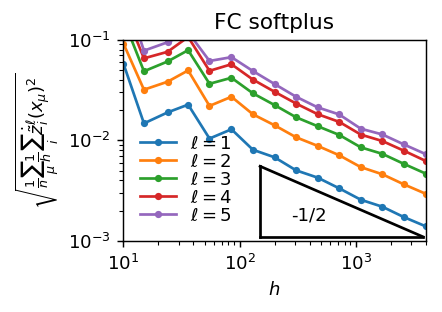

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=130)

hs, ds = torch.load('dot_z.pkl', map_location='cpu')

for i in range(ds[0].size(0)):
    plt.plot(hs, [x[i] for x in ds], '.-', label='$\ell={}$'.format(i + 1))

plt.legend(labelspacing=0, frameon=False)

plt.xscale('log')
plt.yscale('log')
plt.xlim(min(hs), max(hs))
plt.ylim(1e-3, 1e-1)

triangle(3800, 150, 1.1e-3, slope=-1/2, fmt='-1/2', other=True)

plt.xlabel('$h$')
plt.ylabel(r'$\sqrt{\frac{1}{n} \sum_\mu \frac{1}{h} \sum_i \dot{\tilde{z}}^\ell_i (x_\mu) ^2}$')
plt.title('FC softplus')

plt.tight_layout()
plt.savefig('dot_z.pgf')

`python -m grid nd_M10d2L5kP_alpha_sp_1 "python main.py --arch fc_softplus --data_seed 0 --batch_seed 0 --d 10 --L 2 --dataset mnist --ptr 5000 --max_bs 5000 --pte 50000 --train_time 36000 --temp 0 --tau -1000 --init_kernel 1 --final_kernel 1 --delta_kernel 1 --spbeta 5 --spsig 1.40438" --init_seed:int 0 1 2 3 4 5 6 7 8 9 --sqhalpha:float 1e-2 1e5 --h:int 100 400 1600`

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


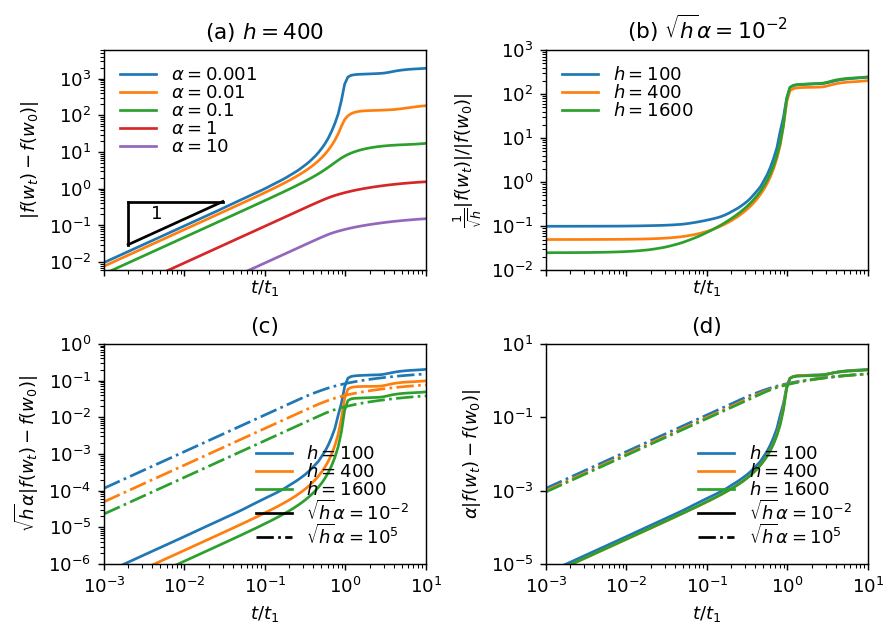

In [43]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(7, 5), dpi=130, sharex=True)

ti = torch.logspace(-3, 1, 100).numpy()


plt.sca(ax1)
runs = load_runs('nd_M10d2L5kP_alpha_sp_1')
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

h = 400
als = [1e-3, 1e-2, 1e-1, 1, 10]

def yavg(xi, x, y):
    import numpy as np
    y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]
    y = np.mean(y, axis=0)
    return xi, y

for a in als:
    rs = [r for r in runs if r['args'].h == h and r['args'].alpha == a]

    label = r'$\alpha={}$'.format(a)

    ts = []
    fs = []

    for r in rs:
        a = r['args'].alpha
        h = r['args'].h
        d = r['regular']['dynamics']
        t1 = next(x['t'] for x in d if x['train']['loss'] * a ** 2 < 0.5)

        t = [x['t'] / t1 for x in d]
        f = [x['test']['dfnorm'] for x in d]
        ts.append(t)
        fs.append(f)
    print(len(fs))

    plt.plot(*yavg(ti, ts, fs), label=label)

plt.yscale('log')

plt.ylabel(r'$\|f(w_t) - f(w_0)\|$')
plt.ylim(3e-4*20, 3e2*20)

plt.xlabel(r'$t/t_1$')

plt.legend(frameon=False, labelspacing=0)

plt.title(r'(a) $h=' + str(h) + '$')




plt.sca(ax2)
runs = load_runs('nd_M10d2L5kP_alpha_sp_1')
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

sqha = 1e-2
hs = [100, 400, 1600]

def yavg(xi, x, y):
    import numpy as np
    y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]
    y = np.mean(y, axis=0)
    return xi, y

for h in hs:
    rs = [r for r in runs if r['args'].h == h and r['args'].sqhalpha == sqha]

    label = r'$h={}$'.format(h)

    ts = []
    fs = []

    for r in rs:
        a = r['args'].alpha
        d = r['regular']['dynamics']
        t1 = next(x['t'] for x in d if x['train']['loss'] * a ** 2 < 0.5)

        t = [x['t'] / t1 for x in d]
        f = [x['test']['fnorm'] / d[0]['test']['fnorm'] / h**0.5 for x in d]
        ts.append(t)
        fs.append(f)
    print(len(fs))

    plt.plot(*yavg(ti, ts, fs), label=label)

plt.yscale('log')

plt.ylabel(r'$\frac{1}{\sqrt{h}} \|f(w_t)\| / \|f(w_0)\|$')
plt.ylim(1e-2, 1e3)

plt.xlabel(r'$t/t_1$')

plt.legend(frameon=False, labelspacing=0)

plt.title(r'(b) $\sqrt{h} \alpha=' + texnum(sqha) + '$')




for ax in [ax3, ax4]:
    plt.sca(ax)
    exp = 0 if ax == ax4 else 0.5
    
    runs = load_runs('nd_M10d2L5kP_alpha_sp_1')
    runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

    sqhas = [1e-2, 1e5]
    sqhas = list(zip(sqhas, ['-', '-.', '--', ':']))
    
    hs = [100, 400, 1600]
    hs = list(zip(hs, plt.rcParams['axes.prop_cycle'].by_key()['color']))

    def yavg(xi, x, y):
        import numpy as np
        y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]
        y = np.mean(y, axis=0)
        return xi, y

    for sqha, linestyle in sqhas:
        for h, color in hs:
            rs = [r for r in runs if r['args'].h == h and r['args'].sqhalpha == sqha]

            label = r'$h={}$'.format(h)

            ts = []
            fs = []

            for r in rs:
                a = r['args'].alpha
                d = r['regular']['dynamics']
                t1 = next(x['t'] for x in d if x['train']['loss'] * a ** 2 < 0.5)

                t = [x['t'] / t1 for x in d]
                f = [a * x['test']['dfnorm'] / h**exp for x in d]
                ts.append(t)
                fs.append(f)
            print(len(fs))

            plt.plot(*yavg(ti, ts, fs), color=color, linestyle=linestyle)

    plt.yscale('log')

    if exp == 0.5:
        plt.ylabel(r'$\sqrt{h} \alpha \|f(w_t) - f(w_0)\|$')
        plt.ylim(1e-6, 1e0)
    if exp == 0.0:
        plt.ylabel(r'$\alpha \|f(w_t) - f(w_0)\|$')
        plt.ylim(1e-5, 1e1)

    plt.xlabel(r'$t/t_1$')

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=color) for h, color in hs] + [Line2D([0], [0], color='k', linestyle=linestyle) for a, linestyle in sqhas]
    texts = [r'$h={}$'.format(h) for h, color in hs] + [r'$\sqrt{{h}} \alpha={}$'.format(texnum(a)) for a, linestyle in sqhas]
    plt.legend(custom_lines, texts, frameon=False, labelspacing=0, loc=4)

plt.sca(ax3)
plt.title(r'(c)')

plt.sca(ax4)
plt.title(r'(d)')

plt.sca(ax1)
triangle(2e-3, 3e-2, 3e-2, slope=1, fmt="1")

plt.xscale('log')
plt.xlim(1e-3, 1e1)
    
plt.tight_layout()
plt.savefig('dfnorm.pgf')

(0.005, 10.0)

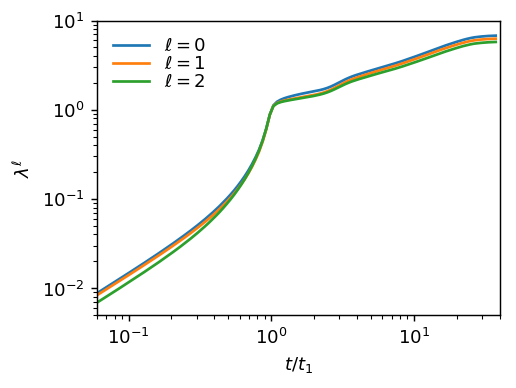

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=130, sharex=True)

runs = load_runs('nd_M10d2L5kP_alpha_sp_1')
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

sqha = 1e-2
hs = [1600]

ti = torch.logspace(-3, 2, 200).numpy()

def yavg(xi, x, y):
    import numpy as np
    xi = np.array(xi)
    xmin = min(np.min(x) for x in x)
    xmax = min(np.max(x) for x in x)
    xi = xi[np.logical_and(xmin < xi, xi < xmax)]
    y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]
    y = np.mean(y, axis=0)
    return xi, y

for h in hs:
    rs = [r for r in runs if r['args'].h == h and r['args'].sqhalpha == sqha]


    for i in range(r['args'].L + 1):
        label = r'$\ell={}$'.format(i)

        ts = []
        fs = []

        for r in rs:
            a = r['args'].alpha
            d = r['regular']['dynamics']
            t1 = next(x['t'] for x in d if x['train']['loss'] * a ** 2 < 0.5)
            t1i = next(i for i, x in enumerate(d) if x['train']['loss'] * a ** 2 < 0.5)

            t = [x['t'] / t1 for x in d]
            f = [x['dwnorm'][i] / d[t1i]['dwnorm'][i] for x in d]
            ts.append(t)
            fs.append(f)

        plt.plot(*yavg(ti, ts, fs), label=label)

plt.yscale('log')

plt.ylabel(r'$\lambda^\ell$')
# plt.ylim(1e-2, 1e3)

plt.xlabel(r'$t/t_1$')

plt.legend(frameon=False, labelspacing=0)

# plt.title(r'(b) $\sqrt{h} \alpha=' + texnum(sqha) + '$')
plt.xscale('log')

plt.xlim(6e-2, 4e1)
plt.ylim(5e-3, 1e1)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1]


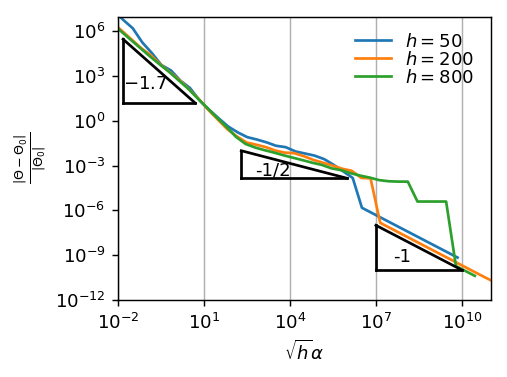

In [46]:
runs = load_runs("nd_M10d5L5kP_alpha_4")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=130)

def thth0(r):
    x = r['init_kernel']['kernel']['test']
    th0 = x['diag'].numel() * (x['mean'] ** 2 + x['std'] ** 2) ** 0.5
    dth = r['delta_kernel']['test']
    return dth / th0

hs = sorted({r['args'].h for r in runs})
hs = [50, 200, 800]

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 3
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a * h ** 0.5 for a in als]
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]

    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))

# y-axis
plt.yscale('log')
plt.ylim(1e-12, 1e7)
plt.ylabel(r'$\frac{\|\Theta - \Theta_0\|}{\|\Theta_0\|}$')

# x-axis
plt.grid(axis='x')
plt.xlim(1e-2, 1e11)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.legend(labelspacing=0, frameon=False)

triangle(1.5e-2, 5e0, 3e5, slope=-1.7, fmt=r"${:.1f}$")
triangle(2e2, 1e6, 1e-2, slope=-1/2, other=False, fmt="-1/2")
triangle(1e7, 1e10, 1e-7, slope=-1, other=False, fmt="-1")

plt.tight_layout()
plt.savefig('relu_th.pgf')

[3, 3, 3, 3, 3, 3, 3, 3, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
3
[5, 5, 5, 5, 5, 5, 5, 5, 5, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 15, 15, 15, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
3
[3, 3, 3, 3, 3, 3, 3, 3, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
3
[3, 3, 3, 3, 3, 3, 3, 3, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1]
3
[1]
3


-1.7

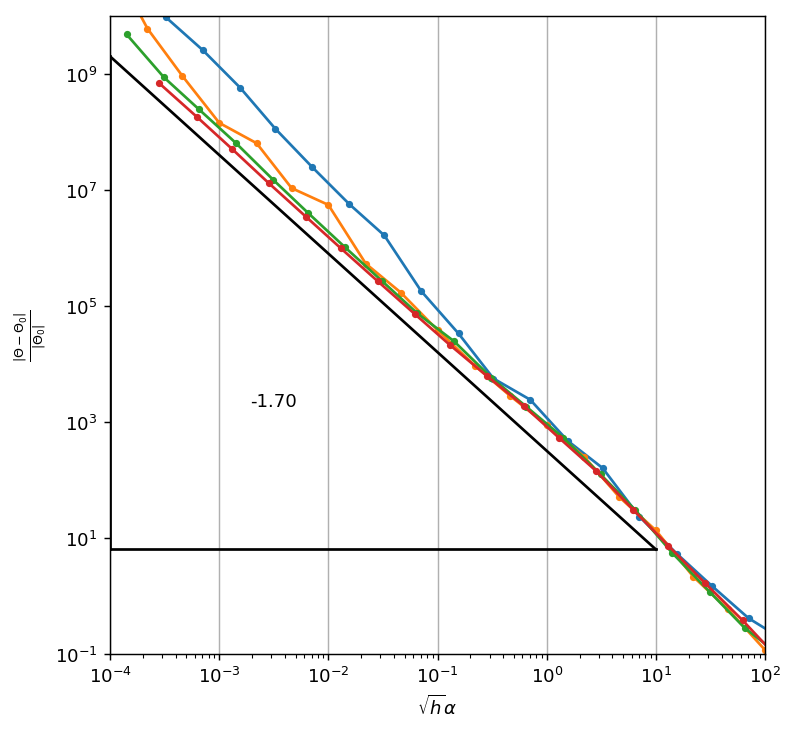

In [47]:
runs = load_runs("nd_M10d5L5kP_alpha_4")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

fig, ax2 = plt.subplots(1, 1, figsize=(6.5, 6.5), dpi=130)

##
def thth0(r):
    x = r['init_kernel']['kernel']['test']
    th0 = x['diag'].numel() * (x['mean'] ** 2 + x['std'] ** 2) ** 0.5
    dth = r['delta_kernel']['test']
    return dth / th0

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 3
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})
    
    ws = [a * h ** 0.5 for a in als]

    plt.sca(ax2)
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(ws, vs, '.-', label=r'$h = {}$'.format(h))
        



# y-axis
plt.sca(ax2)
plt.yscale('log')
plt.ylim(1e-1, 1e10)
plt.sca(ax2)
plt.ylabel(r'$\frac{\|\Theta - \Theta_0\|}{\|\Theta_0\|}$')

# x-axis
plt.sca(ax2)
plt.grid(axis='x')
plt.xlim(1e-4, 1e2)
plt.xscale('log')

plt.sca(ax2)
plt.xlabel(r'$\sqrt{h} \alpha$')

triangle(1e-4, 1e1, 2e9, slope=-1.7)